# Collider Bias

## A selection bias (or collider bias) is a spurious association that arise two variables with a common effect when the common effect is conditioned (or adjusted).

# 1. A toy example

## In this toy example, x and y are independent variables and z is a common effect of x and y as illustrated by the following figure

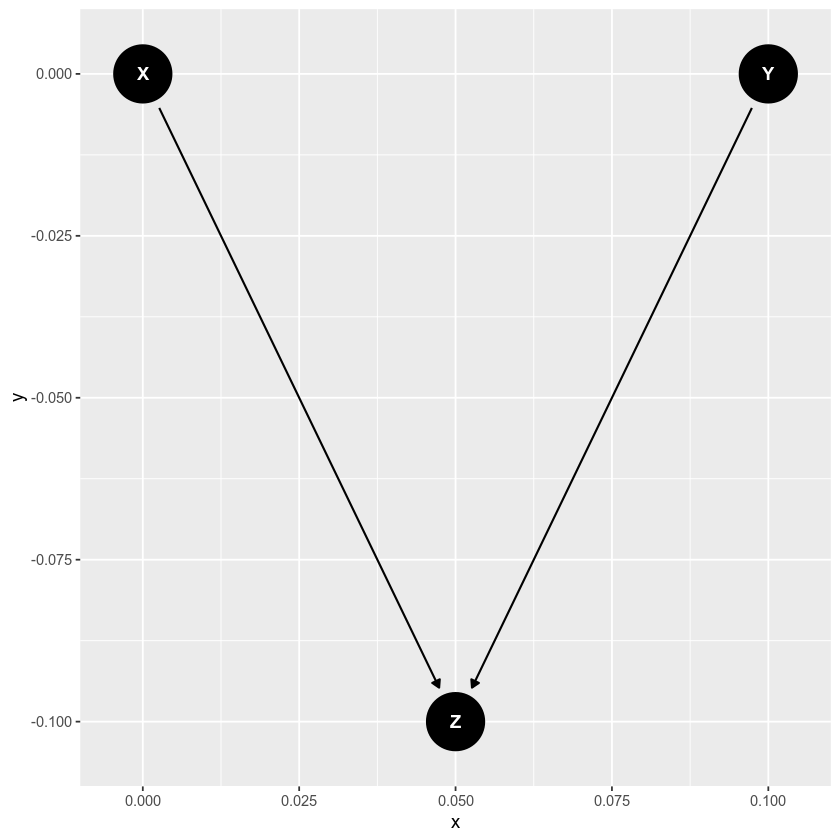

In [43]:
g <- dagitty('dag {
X [exposure,pos="0,0"]
Y [outcome,pos="0.1,0"]
Z [pos="0.05,-0.1"]
X -> Z
Y -> Z
}')
ggdag(g)

$X$ and $Y$ are independent normal random variables
$$ X,Y \sim \mathcal{N}(0,1)$$
and
$$ X \perp Y$$

In [21]:
# x and y are independent: generate 1000 samples
set.seed(0)
x <- rnorm(1000, 0, 1)
y <- rnorm(1000, 0, 1)

As expected, association between two variables is null (P-value > 0.1).

In [22]:
summary(lm(y~x))


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0180 -0.7024 -0.0008  0.7504  3.0451 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.02499    0.03271  -0.764    0.445
x           -0.01307    0.03279  -0.399    0.690

Residual standard error: 1.034 on 998 degrees of freedom
Multiple R-squared:  0.0001593,	Adjusted R-squared:  -0.0008425 
F-statistic: 0.159 on 1 and 998 DF,  p-value: 0.6901


$Z$ is a normal random variable with $X$ and $Y$ as a cause.
$$ Z \sim \mathcal{N}(X+Y, 1)$$

In [23]:
set.seed(0)
z <- x + y + rnorm(1000, 0, 1)

# Conditional on (or adjusting) Z, X and Y are dependent (P-value <2e-16)


In [24]:
summary(lm(y~x+z))

Warning message in summary.lm(lm(y ~ x + z)):
“essentially perfect fit: summary may be unreliable”



Call:
lm(formula = y ~ x + z)

Residuals:
       Min         1Q     Median         3Q        Max 
-8.753e-15 -1.193e-16  2.880e-17  1.578e-16  1.117e-15 

Coefficients:
              Estimate Std. Error    t value Pr(>|t|)    
(Intercept)  1.404e-17  1.274e-17  1.102e+00    0.271    
x           -2.000e+00  2.762e-17 -7.240e+16   <2e-16 ***
z            1.000e+00  1.233e-17  8.112e+16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.028e-16 on 997 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.291e+33 on 2 and 997 DF,  p-value: < 2.2e-16


# 2. Cell-cycle and cell-type

# In this real data example, we simulate a dataset with two cell-types that only differs in terms of read-depth.

## 1. $C$: cell-cycle
## 2. $T$: cell-type
## 3. $R$: read-depth

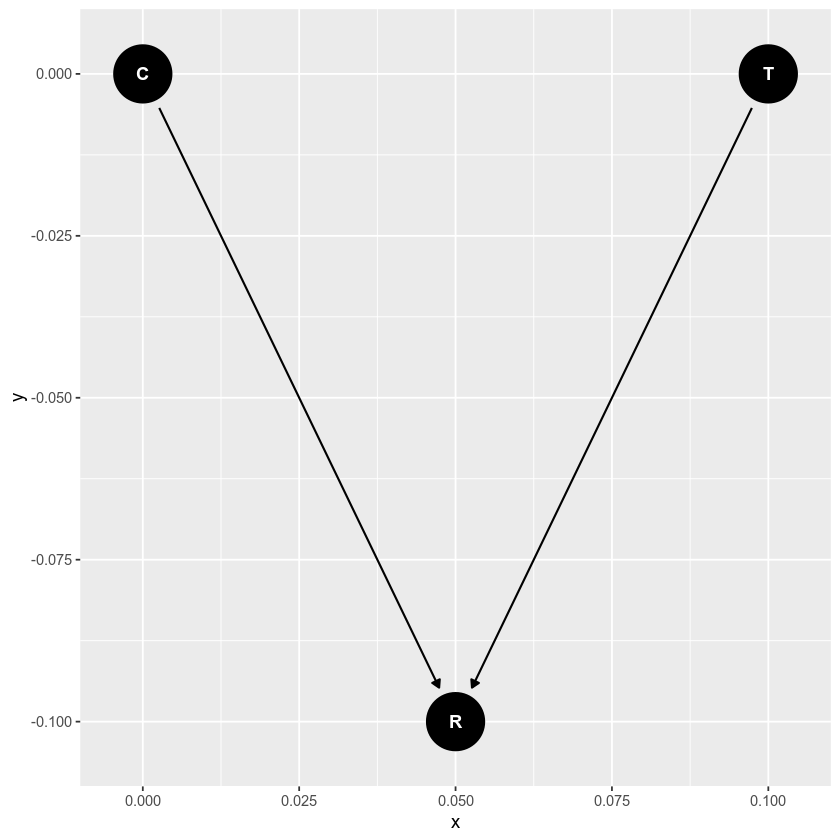

In [44]:
g <- dagitty('dag {
C [exposure,pos="0,0"]
T [outcome,pos="0.1,0"]
R [pos="0.05,-0.1"]
C -> R
T -> R
}')
ggdag(g)

In [46]:
library(Seurat)
# load data
counts <- readMM('../data/fucci/matrix.mtx')
rownames(counts) <- read.csv('../data/fucci/features.tsv')$x
colnames(counts) <- read.csv('../data/fucci/barcodes.tsv')$x
meta <- read.csv('../data/fucci/meta.csv', row.names=1)

In [50]:
# randomly select cell and down-sampele to half depth
obj <- CreateSeuratObject(counts, meta.data=meta)
obj@meta.data$sample <- as.logical(sample(c(TRUE,FALSE), ncol(obj), replace = TRUE))

obj_orig <- subset(obj, subset=(sample == TRUE))
obj_to_ds <- subset(obj, subset=(sample != TRUE))
expr_ds <- apply(obj_to_ds$RNA@counts, c(1,2), function(n){rbinom(1,size=n, prob=0.5)})
obj_ds <- CreateSeuratObject(expr_ds, meta.data=obj_to_ds@meta.data[,4:ncol(obj_to_ds@meta.data)])

obj_orig@meta.data$label <- 'Original'
obj_ds@meta.data$label <- 'Downsampled'
obj_merge <- merge(obj_orig, y=obj_ds)

In [53]:
# R : log read-depth, T : cell-type, C: cell-cycle score
df <- data.frame('x1'=cos(obj_merge@meta.data$theta), 
                 'x2'=sin(obj_merge@meta.data$theta), 
                 'R'=log10(obj_merge@meta.data$nCount_RNA), 
                 'T'=obj_merge@meta.data$label)
df$C <- df$x1-df$x2

## As expected, $R$ and $T$ are indpendent (P-value > 0.1)

In [57]:
summary(lm('C~factor(T)', data=df))


Call:
lm(formula = "C~factor(T)", data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5225 -0.8295  0.1245  0.8300  1.3517 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)  
(Intercept)        0.10857    0.04389   2.474   0.0136 *
factor(T)Original -0.04661    0.06179  -0.754   0.4508  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9206 on 886 degrees of freedom
Multiple R-squared:  0.0006419,	Adjusted R-squared:  -0.000486 
F-statistic: 0.5691 on 1 and 886 DF,  p-value: 0.4508


## However, adjusting read-depth introduces extremely significant association (P-value <2e-16)

In [58]:
summary(lm('C~factor(T)+R', data=df))


Call:
lm(formula = "C~factor(T)+R", data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9492 -0.7090  0.1516  0.7032  2.3323 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -13.0700     1.2066 -10.833   <2e-16 ***
factor(T)Original  -0.9638     0.1020  -9.446   <2e-16 ***
R                   2.9863     0.2732  10.929   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8646 on 885 degrees of freedom
Multiple R-squared:  0.1195,	Adjusted R-squared:  0.1175 
F-statistic: 60.04 on 2 and 885 DF,  p-value: < 2.2e-16
